# Simulated calibration with $C^2$

Calibration of control pulses is the process of fine-tuning parameters in a feedback-loop with the experiment. We will simulate this process here by constructing a black-box simulation and interacting with it exactly like an experiment.

We have manange imports and creation of the black-box the same way as in the previous example in a helper `blackbox_exp.py`.

In [1]:
from blackbox_exp import create_experiment

blackbox = create_experiment()

This blackbox is constructed the same way as in the C1 example. The difference will be in how we interact with it. First, we decide on what experiment we want to perform and need to specify it as a python function. A general, minimal example would be

`def exp_communication(params):
    # Send parameters to experiment controller
    # and recieve a measurement result.
    return measurement_result
 `

Again, `params` is a linear vector of bare numbers. The measurement result can be a single number or a set of results. It can also include additional information about statistics, like averaging, standard deviation, etc.

### ORBIT - Single-length randomized benchmarking
The following defines an [ORBIT](https://arxiv.org/abs/1403.0035) procedure. In short, we define sequences of gates that result in an identity gate if our individual gates are perfect. Any deviation from identity gives us a measure of the imperfections in our gates. Our helper `qt_utils` provides these sequences for two qubits, labeled "left" or "right".

In [2]:
from c3po.utils import qt_utils

In [3]:
qt_utils.single_length_RB(
            RB_number=1, RB_length=5, padding="left"
    )

[['X90p:Id',
  'Y90m:Id',
  'X90p:Id',
  'Id:Id',
  'Y90m:Id',
  'X90p:Id',
  'Id:Id',
  'Id:Id',
  'X90p:Id',
  'Y90p:Id',
  'Id:Id',
  'Id:Id',
  'Id:Id',
  'Id:Id',
  'Id:Id',
  'Id:Id',
  'X90p:Id',
  'Y90p:Id',
  'X90p:Id',
  'Id:Id']]

The desired number of 5 gates is selected from a specific set (the Clifford group) and has to be decomposed into the available gate-set. Here, this means 4 gates per Clifford, hence a sequence of 20 gates.

### Communication with the experiment
Some of the following code is specific to the fact that this a *simulated* calibration.

In [4]:
import itertools
import numpy as np
import tensorflow as tf

def ORBIT(params, exp_right, opt_map, qubit_labels, logdir):
    
    ### ORBIT meta-parameters ###
    RB_length = 100 # How long each sequence is
    RB_number = 25  # How many sequences
    shots = 1000    # How many averages per readout

    ################################
    ### Simulation specific part ###
    ################################
    
    do_noise = True  # Whether to add artificial noise to the results
    
    # Selecting one qubit from the multi-qubit chip #
    qubit_label = list(qubit_labels.keys())[0]
    if len(qubit_labels.keys()) > 1:
        raise Warning(
            'C3:WARNING: Can only do one ORBIT at a time.'
            f"Using qubit label {qubit_label}"
        )
    state_labels = qubit_labels[qubit_label]
    state_label = [tuple(l) for l in state_labels]
    
    # Creating the RB sequences #
    seqs = qt_utils.single_length_RB(
            RB_number=RB_number, RB_length=RB_length, padding=qubit_label
    )

    # Transmitting the parameters to the experiment #
    exp_right.gateset.set_parameters(params, opt_map, scaled=False)
    exp_right.opt_gates = list(
        set(itertools.chain.from_iterable(seqs))
    )
    
    # Simulating the gates #
    U_dict = exp_right.get_gates()
    
    # Running the RB sequences and read-out the results #
    exp_right.evaluate(seqs)
    pop1s = exp_right.process(labels=state_label)

    results = []
    results_std = []
    shots_nums = []

    # Collecting results and statistics, add noise #
    if do_noise:
        for p1 in pop1s:
            draws = tf.keras.backend.random_binomial(
                [shots],
                p=p1[0],
                dtype=tf.float64,
            )
            results.append([np.mean(draws)])
            results_std.append([np.std(draws)/np.sqrt(shots)])
            shots_nums.append([shots])
    else:
        for p1 in pop1s:
            results.append(p1.numpy())
            results_std.append([0])
            shots_nums.append([shots])
    
    #######################################
    ### End of Simulation specific part ###
    #######################################
    
    goal = np.mean(results)
    return goal, results, results_std, seqs, shots_nums

### Optimization
We first import algorithms and the correct optimizer object.

In [5]:
from c3po.libraries import algorithms
from c3po.optimizers.c2 import C2

Next, we define the parameters we whish to calibrate. See how these gate instructions are defined in the experiment setup example. Our gate-set is made up of 4 gates, rotations of 90 degrees around the $x$ and $y$-axis in positive and negative direction. While it is possible to optimize each parameters of each gate individually, in this example all four gates share parameters. They only differ in the phase $\phi_{xy}$ that is set in the definitions.

In [6]:
gateset_opt_map =   [
    [
      ("X90p:Id", "d1", "gauss", "amp"),
      ("Y90p:Id", "d1", "gauss", "amp"),
      ("X90m:Id", "d1", "gauss", "amp"),
      ("Y90m:Id", "d1", "gauss", "amp")
    ],
    [
      ("X90p:Id", "d1", "gauss", "delta"),
      ("Y90p:Id", "d1", "gauss", "delta"),
      ("X90m:Id", "d1", "gauss", "delta"),
      ("Y90m:Id", "d1", "gauss", "delta")
    ],
    [
      ("X90p:Id", "d1", "gauss", "freq_offset"),
      ("Y90p:Id", "d1", "gauss", "freq_offset"),
      ("X90m:Id", "d1", "gauss", "freq_offset"),
      ("Y90m:Id", "d1", "gauss", "freq_offset")
    ],
    [
      ("Id:Id", "d1", "carrier", "framechange"),
      ("Id:X90p", "d1", "carrier", "framechange"),
      ("Id:Y90p", "d1", "carrier", "framechange"),
      ("Id:X90m", "d1", "carrier", "framechange"),
      ("Id:Y90m", "d1", "carrier", "framechange")
    ]
  ]

As defined above, we have 16 parameters where 4 share thier numerical value. This leaves 4 values to optmize.

In [7]:
print(blackbox.gateset.print_parameters(gateset_opt_map))

Y90m:Id-d1-gauss-amp        : 500.000 mV 
Y90m:Id-d1-gauss-delta      : -1.000  
Y90m:Id-d1-gauss-freq_offset: -53.000 MHz 2pi 
Id:Y90m-d1-carrier-framechange: 4.084 rad 



As an optimization algoritm, we choose [CMA-Es](https://en.wikipedia.org/wiki/CMA-ES) and set up some options specific to this algorithm.

In [8]:
alg_options = {
    "popsize" : 5,
    "maxfevals" : 450,
    "init_point" : "True",
    "tolfun" : 0.01,
    "spread" : 0.001
  }

The interface of $C^2$ to the experiment is simple: parameters in -> results out. Thus, we have to wrap the blackbox by defining the target qubit and the `opt_map`.

In [9]:
state_labels = {
      "left" : [[1, 0], [1, 1]]
  }

In [10]:
def ORBIT_wrapper(p):
    return ORBIT(
                p, blackbox, gateset_opt_map, state_labels, "/tmp/c3logs/blackbox"
            )

In the real world, this setup needs to be handled in the experiment controller side.

In [11]:
opt = C2(
    dir_path='/tmp/c3logs/',
    run_name="ORBIT_cal",
    eval_func=ORBIT_wrapper,
    gateset_opt_map=gateset_opt_map,
    algorithm=algorithms.cmaes,
    options=alg_options
)
opt.set_exp(blackbox)

<Figure size 432x288 with 0 Axes>

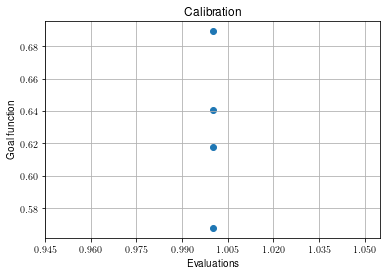

<Figure size 432x288 with 0 Axes>

In [12]:
opt.optimize_controls()